# Vehicle Detection Using HOG+SVM Part 2

In this we will use GTI vehicle image database available here: http://www.gti.ssr.upm.es/data/Vehicle_database.html.
This dataset has cars and non-cars images ~8k. Images are of 64*64 in resolution. The process is follows:
*  Make Dataset.
*  Show some samples.
*  Make HOG features vectors.
*  Train SVM.
*  Predict with SVMs.
*  Make a Detector with sliding window.



In [1]:
from PIL import Image
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage import feature, exposure
import imutils
from sklearn.svm import LinearSVC
from imutils.object_detection import non_max_suppression

In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/train_datasets/cars-noncars.rar", 
                         outdir="/content/")

     |████████████████████████████████| 81kB 2.2MB/s 
patool: Extracting /content/drive/My Drive/train_datasets/cars-noncars.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/train_datasets/cars-noncars.rar"
patool:     with cwd='/content/'
patool: ... /content/drive/My Drive/train_datasets/cars-noncars.rar extracted to `/content/'.


'/content/'

1. Make Dataset

In [3]:
DATA_DIR = '/content/OwnCollection/'
DATA = []
Y = []


def make_dataset(data_dir):

  vehicles_path = os.path.join(data_dir, 'vehicles')
  non_vehicles_path = os.path.join(data_dir, 'non-vehicles')

  for fld in os.listdir(vehicles_path):
    cur_dir = os.path.join(vehicles_path, fld)

    for img in os.listdir(cur_dir):
      if img.endswith(".png"):
        img = np.asarray(Image.open(os.path.join(cur_dir, img)))
        DATA.append(img)
        Y.append(1)

  for fld in os.listdir(non_vehicles_path):
    cur_dir = os.path.join(non_vehicles_path, fld)

    for img in os.listdir(cur_dir):
      if img.endswith(".png"):
        img = np.asarray(Image.open(os.path.join(cur_dir, img)))
        DATA.append(img)
        Y.append(0)

make_dataset(DATA_DIR)

X_train, X_test, Y_train, Y_test = train_test_split(DATA, Y, test_size= 0.3)

print('Total DATA samples:', len(Y))
print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))

Total DATA samples: 7325
Total Train samples: 5127
Total Test samples: 2198


2. Show some samples

Cars:1, Non-cars:0


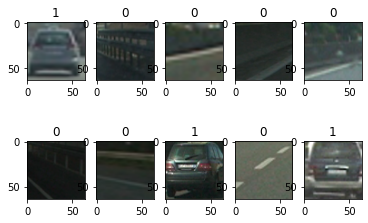

In [ ]:
#show some sample data

r = 2
c = 5
f, axs = plt.subplots(r,c)

a= 0

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(X_train[a])
    axs[i,j].set_title(Y_train[a])
    a+=1
print('Cars:1, Non-cars:0')

As our data is already pre-processed i.e image is 64*64 by defualt, we don't need to do much but for other dataset make sure to preprocess the image to same size(also not losing the image details).

In [ ]:
X_train[0].shape

(64, 64, 3)

3. Show HOG features sample 

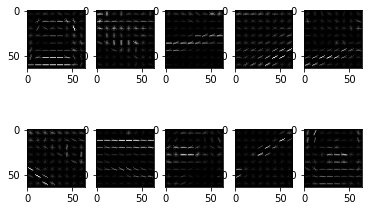

In [ ]:
# sample hog features plot

a = 0
f, axs = plt.subplots(2, 5)
for i in range(r):
  for j in range(c):
    (HOG_features, Hog_image) = feature.hog(X_train[a], 9, visualize=True, 
                                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                                          feature_vector=True)
    img = exposure.rescale_intensity(Hog_image, out_range=(0, 255))
    img = img.astype('int').reshape(64, 64)
    axs[i,j].imshow(img, cmap='gray')
    a+=1


4. Prepare hog features

In [4]:
def make_hog_feaures(image):
  # image values is already normalized under hog function
  Hog_features = feature.hog(image, orientations=9, 
                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                            feature_vector=True)
  return Hog_features

In [5]:
train_features = []

for image in X_train:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hog_features = make_hog_feaures(image)
  train_features.append(hog_features)  

5. Train SVMs on HOG features

In [63]:
# train a svm

svc = LinearSVC(tol=0.0001, random_state=42, C = 1.2, dual=False)
svc.fit(train_features, Y_train)

LinearSVC(C=1.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

6. Predict with SVC

In [64]:
# predict with SVC

correct = 0

for image,label in zip(X_test, Y_test):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  features = make_hog_feaures(image)
  yhat = svc1.predict((features).reshape(1, features.shape[0]))
  if yhat[0] == label:
    correct+=1

print('{0} Correct out of {1}'.format(correct, len(Y_test)))   
print("Accuracy:", correct/len(Y_test)*100)

2106 Correct out of 2198
Accuracy: 95.81437670609645


Cars:1, Non-cars:0


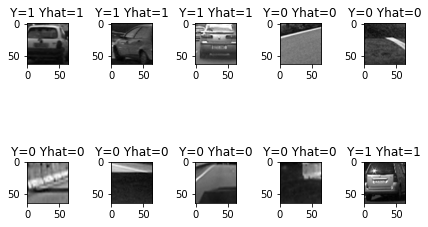

In [ ]:
# SVC results

a = 0
f, axs = plt.subplots(2, 5)
f.tight_layout()
for i in range(r):
  for j in range(c):

    image = cv2.cvtColor(X_test[a], cv2.COLOR_BGR2GRAY)
    features = make_hog_feaures(image)
    yhat = svc1.predict((features).reshape(1, features.shape[0]))
    axs[i,j].imshow(image, cmap='gray')
    axs[i,j].set_title("Y={0} Yhat={1}".format(Y_test[a], yhat[0]))
    a+=1
print('Cars:1, Non-cars:0')

Make detector with sliding window

In [60]:


DIR = '/content/drive/My Drive/photos/'

def sliding_window(image, stride, windowSize): 
	# slide a window across the image(from pyimagesearch)
	for y in range(0, image.shape[0], stride):
		for x in range(0, image.shape[1], stride):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
   
def detect_car(image, pyr_levels = 3):
    rects = []
    offset = int(image.shape[0]/2) # to miss the sky, start from half row of the image
    new_img = image[offset:, :] 
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    # apply pyramids
    for i in range(pyr_levels):
       for (x, y, window) in sliding_window(gray, stride=10, windowSize=(64, 64)):
          if window.shape[0] != 64 or window.shape[1] != 64:
	          continue
          feature = make_hog_feaures(window)  
          yhat = svc1.predict((feature).reshape(1, feature.shape[0]))
          svc.predict_proba
          if yhat == 1:
              rects.append([x, y, x+64, y+64]) # collect all rects which have cars
       gray = cv2.pyrDown(gray)

    # apply non-max suppression 
    final_boxes = non_max_suppression(np.array(rects), overlapThresh=0.2)
    for (x1,y1,x2,y2) in final_boxes:
        cv2.rectangle(image, (x1, y1+ offset), (x2, y2+ offset), (0,255,0), 2)   
    return image

for i, image in enumerate(os.listdir(DIR)):
  if i == 11:
    image = cv2.imread(DIR + image)
    img = detect_car(image)
    break 
print('Done')

Done


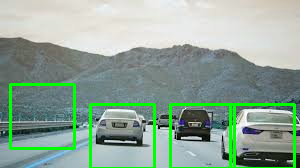

In [61]:
Image.fromarray(img)

**Summary**: As in part 2 the results weren't that satisfying but still managable and there is plenty room for improvements. Using sliding window, image pyramids and non-max supperession we contructed an classic object detector using HOG+SVM. One problem I faced was the boxes, the aspect ratio of box is 64*64, which is not sufficient for image with huge cars object, and with small objects the boxes stay large(if object is small but still detected), with known pyr scaler ratio it might be fixed. we can resize the image before inputing it to the detector but still it needs some improvements. Even though this method is capable of detecting cars in many situations(highways) where the cars can be at a distance.  

Improvements:
* Better SVM parameters.
* Variable sizes of boxes.
* Solution for bigger objects(more than 64*64 res car dataset)
* Neat sliding window implementation.
* Use another algorithm with predict_proba and set some thershold.
* As always, More data.

